## Compare photometry in the new  Stripe82 catalog 
## to Gaia DR2 photometry and derive corrections for 
## gray systematics using Gmag photometry

#### input: N2020_stripe82calibStars.dat
#### output: stripe82calibStars_v3.1.dat 
#### files with RA/Dec corrections: ZPcorrectionsRA_v3.1_final.dat and ZPcorrectionsDec_v3.1_final.dat
### makes paper plots:  
### GmagCorrection_RA_Hess.png  GmagCorrection_Dec_Hess.png	
### GmagCorrectionTest_Gmag_Hess.png

In [1]:
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from astroML.plotting import hist
# for astroML installation see https://www.astroml.org/user_guide/installation.html

In [2]:
## automatically reload any modules read below that might have changed (e.g. plots)
%load_ext autoreload
%autoreload 2
# importing ZI and KT tools: 
import ZItools as zit
import KTtools as ktt

<a id='dataReading'></a>

### Define paths and catalogs 

In [3]:
ZIdataDir = "/Users/ivezic/Work/Science/CalibrationV2/SDSS_SSC/Data"
# the original SDSS catalog from 2007
sdssOldCat = ZIdataDir + "/" + "stripe82calibStars_v2.6.dat"
# INPUT: Karun's new catalog from 2020
sdssNewCatIn = ZIdataDir + "/" + "N2020_stripe82calibStars.dat"
readFormat = 'csv'
# OUTPUT: with Gmag-based gray corrections 
sdssNewCatOut = ZIdataDir + "/" + "stripe82calibStars_v3.1.dat" 
# Gaia DR2 
GaiaDR2Cat = ZIdataDir + "/" + "Stripe82_GaiaDR2.dat"
# Gaia DR2 with BP and RP data
GaiaDR2CatBR = ZIdataDir + "/" + "Stripe82_GaiaDR2_BPRP.dat" 

In [4]:
# both new and old files use identical data structure
colnamesSDSS = ['calib_fla', 'ra', 'dec', 'raRMS', 'decRMS', 'nEpochs', 'AR_val', 
                'u_Nobs', 'u_mMed', 'u_mMean', 'u_mErr', 'u_rms_scatt', 'u_chi2',
                'g_Nobs', 'g_mMed', 'g_mMean', 'g_mErr', 'g_rms_scatt', 'g_chi2',
                'r_Nobs', 'r_mMed', 'r_mMean', 'r_mErr', 'r_rms_scatt', 'r_chi2',
                'i_Nobs', 'i_mMed', 'i_mMean', 'i_mErr', 'i_rms_scatt', 'i_chi2',
                'z_Nobs', 'z_mMed', 'z_mMean', 'z_mErr', 'z_rms_scatt', 'z_chi2']

In [5]:
%%time
# old
sdssOld = Table.read(sdssOldCat, format='ascii', names=colnamesSDSS) 
np.size(sdssOld)

CPU times: user 23.1 s, sys: 4.49 s, total: 27.5 s
Wall time: 26.7 s


1006849

In [6]:
%%time
# new 
sdssNew = Table.read(sdssNewCatIn, format=readFormat, names=colnamesSDSS)
np.size(sdssNew)

CPU times: user 4.81 s, sys: 1.1 s, total: 5.91 s
Wall time: 5.05 s


1001335

#### Simple positional match using ra/dec

In [7]:
sdssOld_coords = SkyCoord(ra = sdssOld['ra']*u.degree, dec= sdssOld['dec']*u.degree) 
sdssNew_coords = SkyCoord(ra = sdssNew['ra']*u.degree, dec= sdssNew['dec']*u.degree) 
# this is matching sdssNew to sdssOld, so that indices are into sdssNew catalog
# makes sense in this case since the sdssOld catalog is (a little bit) bigger 
# than sdssNew (1006849 vs 1005470)
idx, d2d, d3d = sdssNew_coords.match_to_catalog_sky(sdssOld_coords)  

In [8]:
# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
new_old = hstack([sdssNew, sdssOld[idx]], table_names = ['new', 'old'])
new_old['sep_2d_arcsec'] = d2d.arcsec
# good matches between the old and new catalogs
MAX_DISTANCE_ARCSEC = 0.5
sdss = new_old[(new_old['sep_2d_arcsec'] < MAX_DISTANCE_ARCSEC)]
print(np.size(sdss))

1000140


### apply standard cuts as in old catalog:


In [9]:
mOK3 = sdss[sdss['ra_new']<1]
mOK3 = zit.selectCatalog(sdss, mOK3)

starting with 1000140
after Nobs cuts: 996147
after chi2 cuts: 993774
after r_mErr cut: 991472


In [10]:
print(996147/1006849)
print(993774/1006849)
print(991472/1006849)

0.989370799394944
0.9870139415145668
0.9847276006630588


### now match to Gaia DR2...

In [11]:
colnamesGaia = ['ra', 'dec', 'nObs', 'Gmag', 'flux', 'fluxErr', 'pmra', 'pmdec']
colnamesGaia = colnamesGaia + ['BPmag', 'BPeI', 'RPmag', 'RPeI', 'BRef']
gaia = Table.read(GaiaDR2CatBR, format='ascii', names=colnamesGaia)
gaia['raG'] = gaia['ra']
gaia['decG'] = gaia['dec']    
gaia['GmagErr'] = gaia['fluxErr'] / gaia['flux'] 
gaia['BR'] = gaia['BPmag'] - gaia['RPmag'] 
gaia['GBP'] = gaia['Gmag'] - gaia['BPmag']
gaia['GRP'] = gaia['Gmag'] - gaia['RPmag']

In [12]:
sdss_coords = SkyCoord(ra = sdss['ra_old']*u.degree, dec= sdss['dec_old']*u.degree) 
gaia_coords = SkyCoord(ra = gaia['raG']*u.degree, dec= gaia['decG']*u.degree) 

# this is matching gaia to sdss, so that indices are into sdss catalog
# makes sense in this case since the sdss catalog is bigger than gaia
idxG, d2dG, d3dG = gaia_coords.match_to_catalog_sky(sdss_coords)  

# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
gaia_sdss = hstack([gaia, sdss[idxG]], table_names = ['gaia', 'sdss'])
gaia_sdss['sepSG_2d_arcsec'] = d2dG.arcsec

In [13]:
### code for generating new quantities, such as dra, ddec, colors, differences in mags, etc
def derivedColumns(matches):
    matches['dra'] = (matches['ra_new']-matches['ra_old'])*3600
    matches['ddec'] = (matches['dec_new']-matches['dec_old'])*3600
    matches['ra'] = matches['ra_old']
    ra = matches['ra'] 
    matches['raW'] = np.where(ra > 180, ra-360, ra) 
    matches['dec'] = matches['dec_old']
    matches['u'] = matches['u_mMed_old']
    matches['g'] = matches['g_mMed_old']
    matches['r'] = matches['r_mMed_old']
    matches['i'] = matches['i_mMed_old']
    matches['z'] = matches['z_mMed_old']
    matches['ug'] = matches['u_mMed_old'] - matches['g_mMed_old']
    matches['gr'] = matches['g_mMed_old'] - matches['r_mMed_old']
    matches['ri'] = matches['r_mMed_old'] - matches['i_mMed_old']
    matches['gi'] = matches['g_mMed_old'] - matches['i_mMed_old']
    matches['du'] = matches['u_mMed_old'] - matches['u_mMed_new']
    matches['dg'] = matches['g_mMed_old'] - matches['g_mMed_new']
    matches['dr'] = matches['r_mMed_old'] - matches['r_mMed_new']
    matches['di'] = matches['i_mMed_old'] - matches['i_mMed_new']
    matches['dz'] = matches['z_mMed_old'] - matches['z_mMed_new']
    # Gaia 
    matches['draGold'] = -3600*(matches['ra_old'] - matches['raG']) 
    matches['draGnew'] = -3600*(matches['ra_new'] - matches['raG']) 
    matches['ddecGold'] = -3600*(matches['dec_old'] - matches['decG']) 
    matches['ddecGnew'] = -3600*(matches['dec_new'] - matches['decG']) 
    # photometric
    matches['gGr_old'] = matches['Gmag'] - matches['r_mMed_old']
    matches['gGr_new'] = matches['Gmag'] - matches['r_mMed_new']
    matches['gRPr_new'] = matches['RPmag'] - matches['r_mMed_new']
    return

In [14]:
derivedColumns(gaia_sdss) 

### Select good matches and compare both catalogs to Gaia DR2

In [15]:
# doGaiaAll(mOK)
def doGaiaGmagCorrection(d, Cstr, Gmax=20.0, yMax=0.03):
    # Cstr = 'gGr_old' or 'gGr_new'  
    gi = d['gi']
    Gr = d[Cstr]
    Gmag = d['Gmag']
    zit.qpBM(d, 'gi', -1, 4.5, Cstr, -2, 1.0, 56) 

    xBin, nPts, medianBin, sigGbin = zit.fitMedians(gi, Gr, -0.7, 4.0, 47, 0)  
    data = np.array([xBin, medianBin, sigGbin])
    Ndata = xBin.size
    ### HERE WE ARE FITTING 7-th ORDER POLYNOMIAL TO Gmag-rSDSS vs. g-i ###
    # get best-fit parameters  
    thetaCloc = zit.best_theta(data,7)
    # generate best fit lines on a fine grid 
    xfit = np.linspace(-1.1, 4.3, 1000)
    yfit = zit.polynomial_fit(thetaCloc, xfit) 
    ## added "Poly" because switched to piecewise linear interpolation below
    d['gGrFitPoly'] = zit.polynomial_fit(thetaCloc, gi)
    d['dgGrPoly'] = d[Cstr] - d['gGrFitPoly']  
    ### PIECEWISE LINEAR INTERPOLATION (AS FOR ALL OTHER COLORS AND SURVEYS)
    d['gGrFit'] = np.interp(gi, xBin, medianBin)
    d['dgGr'] = d[Cstr] - d['gGrFit']   
    
    # SELECT FOR RECALIBRATION wrt RA and Dec
    giMin = 0.4
    giMax = 3.0 
    Dc = d[(d['gi']>giMin)&(d['gi']<giMax)]
    print('N before and after color cut:', np.size(d), np.size(Dc))
    DcB = Dc[(Dc['Gmag']>14.5)&(Dc['Gmag']<Gmax)]
    DcB['GrResid'] = DcB['dgGr'] - np.median(DcB['dgGr'])
    zit.printStats(DcB['dgGr'])
    DcBok = DcB[np.abs(DcB['dgGr'])<0.1]
    print(np.size(DcB), np.size(DcBok))

    zit.qpBM(DcBok, 'Gmag', 14.5, Gmax, 'GrResid', -1*yMax, yMax, 56) 
    zit.qpBM(DcBok, 'dec', -1.3, 1.3, 'GrResid', -1*yMax, yMax, 126) 
    zit.qpBM(DcBok, 'raW', -51.5, 60, 'GrResid', -1*yMax, yMax, 112) 
    
    return thetaCloc, DcBok 

In [16]:
## first limit astrometric distance and 
## require at least 4 epochs as in the old catalog
MAX_DISTANCE_ARCSEC = 0.5
m1 = gaia_sdss[(gaia_sdss['sepSG_2d_arcsec'] < MAX_DISTANCE_ARCSEC)]
a1 = m1['g_Nobs_new']
a2 = m1['r_Nobs_new']
a3 = m1['i_Nobs_new']
mOK = m1[(a1>3)&(a2>3)&(a3>3)]
print(len(new_old))
print(len(m1))
print(len(mOK))

1001335
893215
889597


In [17]:
def plotAstro2Ddiagrams(d):
    ### plots 
    plotNameRoot = 'astroVSpm_RA_pm'
    plotName = plotNameRoot + '.png'    
    kw = {"Xstr":'pmra', "Xmin":-40, "Xmax":40, "Xlabel":'R.A. proper motion (mas/yr)', \
          "Ystr":'draGnew', "Ymin":-0.5, "Ymax":0.5, "Ylabel":'raw SDSS R.A. - Gaia R.A. (arcsec)', \
          "XminBin":-35, "XmaxBin":35, "nBin":70, \
          "plotName":plotName, "Nsigma":0, "offset":-0.1, "symbSize":0.05}
    kw["nBinX"] = 90
    kw["nBinY"] = 40
    kw["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(d, kw)
    print('made plot', plotName)

    # need to fit draGnew vs. pmra and correct for the mean trend, then plot vs. r mag
    pmra = d['pmra']
    draGnew = d['draGnew']
    xBin, nPts, medianBin, sigGbin = zit.fitMedians(pmra, draGnew, -60, 60, 120, 0)  
    ### PIECEWISE LINEAR INTERPOLATION 
    d['draGnewFit'] = np.interp(d['pmra'], xBin, medianBin)
    draCorr = d['draGnew'] - d['draGnewFit'] 
    draCorrOK = np.where(np.abs(draCorr) < 0.25, draCorr, 0)
    d['draGnewCorr'] = draCorrOK   

    plotNameRoot = 'astroVSpm_RA_r'
    plotName = plotNameRoot + '.png'  
    kw = {"Xstr":'r_mMed_new', "Xmin":14, "Xmax":21, "Xlabel":'R.A. proper motion (mas/yr)', \
          "Ystr":'draGnewCorr', "Ymin":-0.12, "Ymax":0.12, "Ylabel":'corr. SDSS R.A. - Gaia R.A. (arcsec)', \
          "XminBin":14, "XmaxBin":21, "nBin":30, \
          "plotName":plotName, "Nsigma":0, "offset":0.050, "symbSize":0.05}
    kw["nBinX"] = 30
    kw["nBinY"] = 24
    kw["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(d, kw)
    print('made plot', plotName)


    plotNameRoot = 'astroVSpm_Dec_pm'
    plotName = plotNameRoot + '.png'    
    kw = {"Xstr":'pmdec', "Xmin":-40, "Xmax":40, "Xlabel":'Dec. proper motion (mas/yr)', \
          "Ystr":'ddecGnew', "Ymin":-0.5, "Ymax":0.5, "Ylabel":'raw SDSS Dec. - Gaia Dec. (arcsec)', \
          "XminBin":-35, "XmaxBin":35, "nBin":70, \
          "plotName":plotName, "Nsigma":0, "offset":-0.1, "symbSize":0.05}
    kw["nBinX"] = 90
    kw["nBinY"] = 40
    kw["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(d, kw)
    print('made plot', plotName)

medianAll: 0.011837668330372253 std.dev.All: 0.08291540197481026
N= 889597 min= -0.6731191626613509 max= 0.8241856424092475
median: -0.0010176671537465154 std.dev: 0.2466689101756713
saved plot as: astroVSpm_RA_pm.png


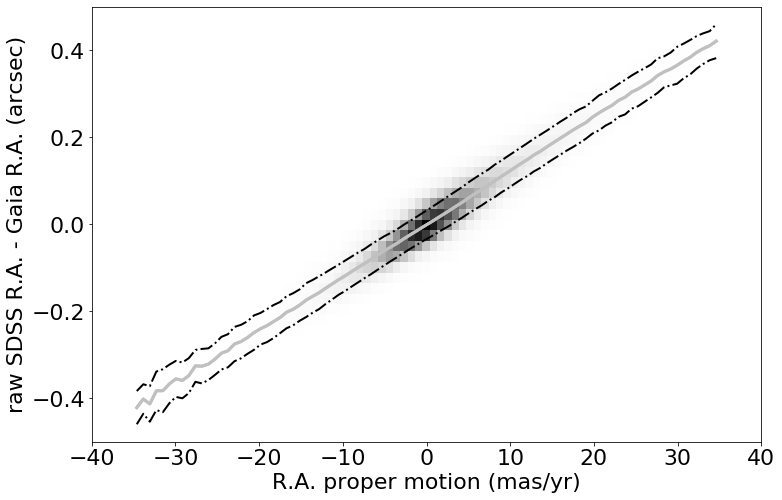

made plot astroVSpm_RA_pm.png
medianAll: 0.0 std.dev.All: 0.027540824673774868
N= 889597 min= -0.24929985582619088 max= 0.2476815018601465
median: 5.075245911840068e-05 std.dev: 0.0017495101171348694
saved plot as: astroVSpm_RA_r.png


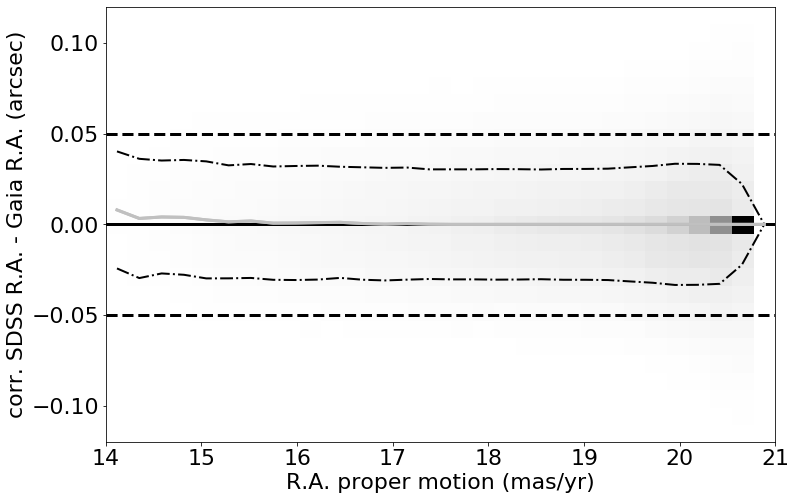

made plot astroVSpm_RA_r.png
medianAll: -0.06565346486704371 std.dev.All: 0.06796036156734564
N= 889597 min= -0.6175474006224757 max= 0.5315962463330881
median: -0.007075151589197581 std.dev: 0.24941016932198606
saved plot as: astroVSpm_Dec_pm.png


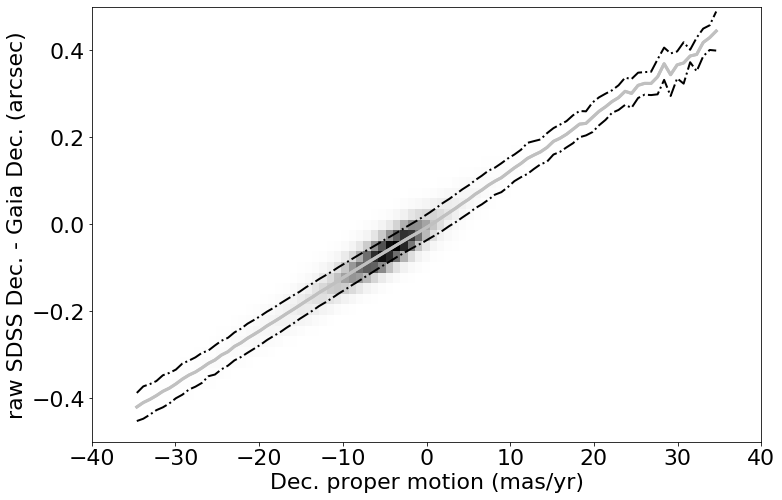

made plot astroVSpm_Dec_pm.png


In [18]:
### produce astrometric plots showing correlation with proper motions
plotAstro2Ddiagrams(mOK)
# print(np.std(mOK['draGnew']), np.std(mOK['ddecGnew'])) 
#mOK

In [19]:
x = mOK['draGnewCorr']
xOK = x[np.abs(x)<0.25]
print(np.std(xOK), zit.sigG(xOK))

0.034068440266785405 0.027540824673774868


medianAll: 0.011837668330372253 std.dev.All: 0.08291540197481026
N= 889597 min= -0.6731191626613509 max= 0.8241856424092475
median: -0.0010321195418327989 std.dev: 0.34466144295567874


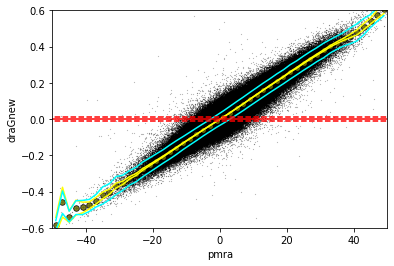

In [20]:
zit.qpBM(mOK, 'pmra', -50, 50, 'draGnew', -0.6, 0.6, 50) 

medianAll: -0.06565346486704371 std.dev.All: 0.06796036156734564
N= 889597 min= -0.6175474006224757 max= 0.5315962463330881
median: -0.041050389020824696 std.dev: 0.31670994131297314


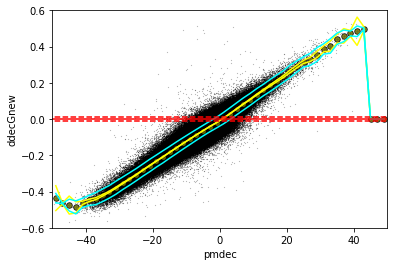

In [21]:
zit.qpBM(mOK, 'pmdec', -50, 50, 'ddecGnew', -0.6, 0.6, 50) 

medianAll: 0.02223904724121084 std.dev.All: 0.2044741988983161
N= 889597 min= -5.769618420410158 max= 10020.286739608764
median: -0.07713654937744074 std.dev: 669.1561831821531


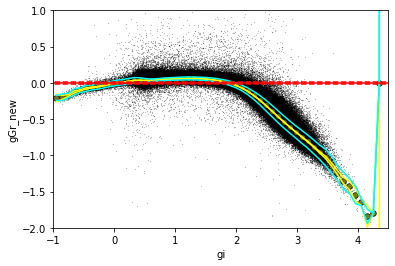

N before and after color cut: 889597 843657
            -5.662821796173096 12.610134918407395 -0.004525382904051967 10019.54848112903 538429
538429 522196
medianAll: -0.0001103688735962366 std.dev.All: 0.01901015718536063
N= 522196 min= -0.09547094892883484 max= 0.10451890780639522
median: -0.0018705645828247207 std.dev: 0.0041309402988762775


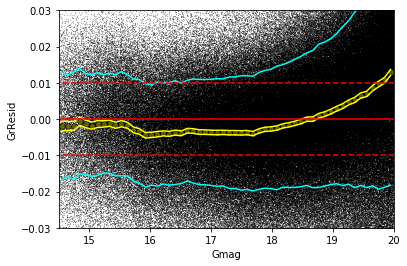

medianAll: -0.0001103688735962366 std.dev.All: 0.01901015718536063
N= 522196 min= -0.09547094892883484 max= 0.10451890780639522
median: 0.0002241651916486745 std.dev: 0.006271589834943464


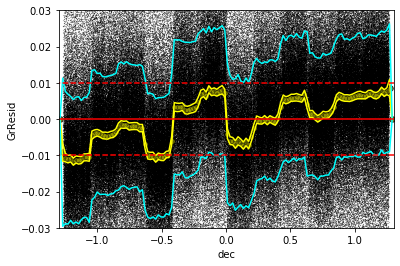

medianAll: -0.0001103688735962366 std.dev.All: 0.01901015718536063
N= 522196 min= -0.09547094892883484 max= 0.10451890780639522
median: -0.0005480622978210926 std.dev: 0.0035048454508462418


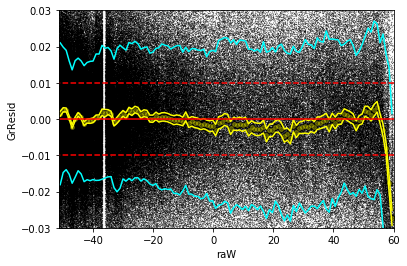

In [22]:
theta, mOKc = doGaiaGmagCorrection(mOK, 'gGr_new')
thetaLoc = theta

In [23]:
## for zero point calibration, in addition to color cut in doGaiaAll, take 16 < G < 19.5 
mOKcB = mOKc[(mOKc['Gmag']>16)&(mOKc['Gmag']<19.5)]
mOKcB['GrResid'] = mOKcB['dgGr'] - np.median(mOKcB['dgGr'])
mOKcBok = mOKcB[np.abs(mOKcB['dgGr'])<0.1]
print(np.size(mOKc), np.size(mOKcB), np.size(mOKcBok))

522196 372447 372447


In [24]:
print(np.std(mOKcBok['GrResid']), zit.sigG(mOKcBok['GrResid'])) 

0.02500946357875863 0.017642210533058877


medianAll: 0.0 std.dev.All: 0.017642210533058877
N= 372447 min= -0.09419973519897318 max= 0.10578642427063098
median: 0.0005424363441502451 std.dev: 0.006249026480933749


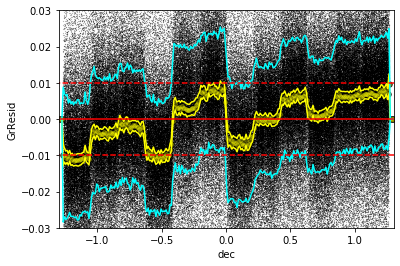

In [25]:
zit.qpBM(mOKcBok, 'dec', -1.3, 1.3, 'GrResid', -0.03, 0.03, 260) 

medianAll: 0.0 std.dev.All: 0.017642210533058877
N= 372447 min= -0.09419973519897318 max= 0.10578642427063098
median: -0.0008380263824436969 std.dev: 0.0034943776777776048


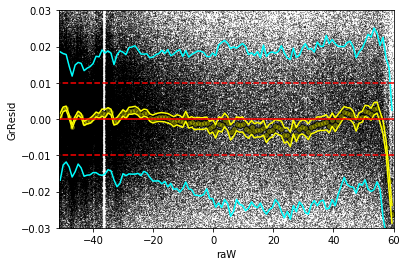

In [26]:
zit.qpBM(mOKcBok, 'raW', -51.5, 60, 'GrResid', -0.03, 0.03, 112) 

# Final Figures for the Paper 
## with Karun's 2D histogram implementation

In [27]:
def plotGmag2Ddiagrams(d):
    ### plots 
    plotNameRoot = 'GrVSgi'
    plotName = plotNameRoot + '.png'    
    kw = {"Xstr":'gi', "Xmin":0.0, "Xmax":3.5, "Xlabel":'SDSS g-i', \
          "Ystr":'gGr_new', "Ymin":-1.25, "Ymax":0.25, "Ylabel":'Gaia Gmag - SDSS r', \
          "XminBin":-0.5, "XmaxBin":4.0, "nBin":90, \
          "plotName":plotName, "Nsigma":3, "offset":0.0, "symbSize":0.05}
    kw["nBinX"] = 90
    kw["nBinY"] = 40
    kw["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(d, kw)
    print('made plot', plotName)

def plotGmag2DdiagramsX(d, kw):
    # Gaia G
    print('-----------')
    print(' stats for SDSS r binning medians:')
    plotName = plotNameRoot + '_Gmag.png'    
    kwOC = {"Xstr":'Gmag', "Xmin":14.3, "Xmax":21.01, "Xlabel":'Gaia G (mag)', \
          "Ystr":kw['Ystr'], "Ymin":-0.06, "Ymax":0.06, "Ylabel":Ylabel, \
          "XminBin":14.5, "XmaxBin":21.0, "nBin":130, \
          "plotName":plotName, "Nsigma":3, "offset":0.01, "symbSize":kw['symbSize']}
    zit.plotdelMag(goodC, kwOC)
    plotName = plotNameRoot + '_Gmag_Hess.png'    
    kwOC["plotName"] = plotName
    kwOC["nBinX"] = 130
    kwOC["nBinY"] = 50
    kwOC["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(goodC, kwOC)
    print('made plot', plotName)
    print('------------------------------------------------------------------')

In [28]:
def plotGmagCorrections(d, kw):
    ### REDEFINE residuals to correspond to "SDSS-others", as other cases
    d['redef'] = -1*d[kw['Ystr']] 
    kw['Ystr'] = 'redef'
    goodC = d[np.abs(d['redef'])<0.1]
    
    ### plots 
    plotNameRoot = kw['plotNameRoot']
    # RA
    print(' stats for RA binning medians:')
    plotName = plotNameRoot + '_RA.png'
    Ylabel = 'residuals for (Gmag$_{SDSS}$ - Gmag$_{GaiaDR2}$)  '
    kwOC = {"Xstr":'raW', "Xmin":-52, "Xmax":60.5, "Xlabel":'R.A. (deg)', \
          "Ystr":kw['Ystr'], "Ymin":-0.07, "Ymax":0.07, "Ylabel":Ylabel, \
          "XminBin":-51.5, "XmaxBin":60, "nBin":112, \
          "plotName":plotName, "Nsigma":3, "offset":0.01, "symbSize":kw['symbSize']}
    zit.plotdelMag(goodC, kwOC)
    plotName = plotNameRoot + '_RA_Hess.png'    
    kwOC["plotName"] = plotName
    kwOC["nBinX"] = 112
    kwOC["nBinY"] = 50
    kwOC["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(goodC, kwOC)  
    print('made plot', plotName)

    # Dec
    print('-----------')
    print(' stats for Dec binning medians:')
    plotName = plotNameRoot + '_Dec.png'
    kwOC = {"Xstr":'dec', "Xmin":-1.3, "Xmax":1.3, "Xlabel":'Declination (deg)', \
          "Ystr":kw['Ystr'], "Ymin":-0.07, "Ymax":0.07, "Ylabel":Ylabel, \
          "XminBin":-1.266, "XmaxBin":1.264, "nBin":252, \
          "plotName":plotName, "Nsigma":3, "offset":0.01, "symbSize":kw['symbSize']}
    zit.plotdelMag(goodC, kwOC)
    plotName = plotNameRoot + '_Dec_Hess.png'    
    kwOC["plotName"] = plotName
    kwOC["nBinX"] = 252  
    kwOC["nBinY"] = 50
    kwOC["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(goodC, kwOC)
    print('made plot', plotName)   
    
    # Gaia G
    print('-----------')
    print(' stats for SDSS r binning medians:')
    plotName = plotNameRoot + '_Gmag.png'    
    kwOC = {"Xstr":'Gmag', "Xmin":14.3, "Xmax":21.01, "Xlabel":'Gaia G (mag)', \
          "Ystr":kw['Ystr'], "Ymin":-0.06, "Ymax":0.06, "Ylabel":Ylabel, \
          "XminBin":14.5, "XmaxBin":21.0, "nBin":130, \
          "plotName":plotName, "Nsigma":3, "offset":0.01, "symbSize":kw['symbSize']}
    zit.plotdelMag(goodC, kwOC)
    plotName = plotNameRoot + '_Gmag_Hess.png'    
    kwOC["plotName"] = plotName
    kwOC["nBinX"] = 130
    kwOC["nBinY"] = 50
    kwOC["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(goodC, kwOC)
    print('made plot', plotName)
    print('------------------------------------------------------------------')
 

In [48]:
mOK['GrResid'] = mOK['dgGr'] - np.median(mOK['dgGr']) + 0.006
mOKok = mOK[np.abs(mOK['dgGr'])<0.1]
print(np.size(mOK), np.size(mOKok))

889597 828147


 stats for RA binning medians:
medianAll: -0.005169725051879749 std.dev.All: 0.026661151840508168
N= 823148 min= -0.09999994224548309 max= 0.09396131709289651
median: -0.005111351123810439 std.dev: 0.0030557093928594457
saved plot as: GmagCorrection_RA.png


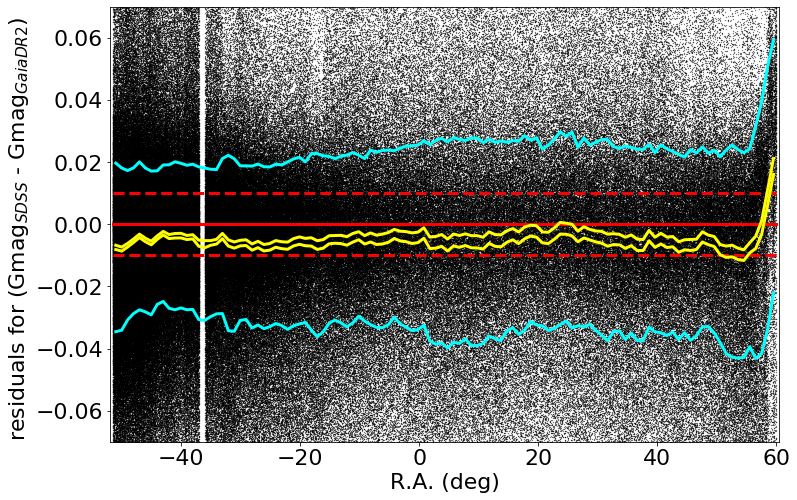

medianAll: -0.005169725051879749 std.dev.All: 0.026661151840508168
N= 823148 min= -0.09999994224548309 max= 0.09396131709289651
median: -0.005111351123810439 std.dev: 0.0030557093928594457
saved plot as: GmagCorrection_RA_Hess.png


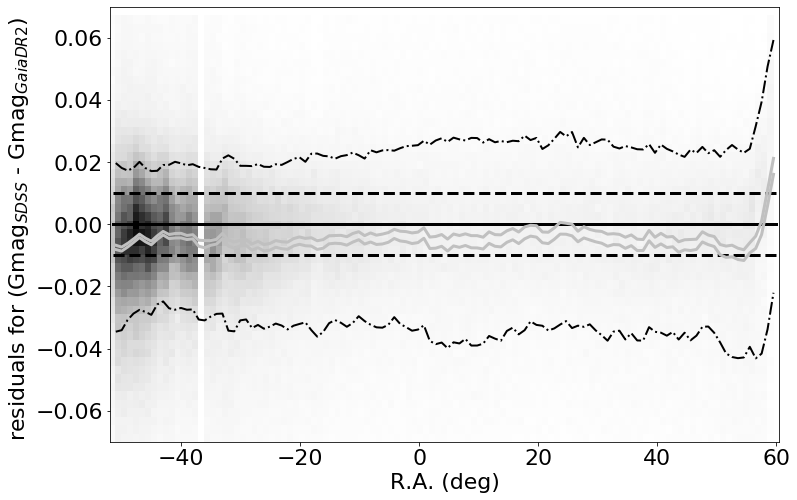

made plot GmagCorrection_RA_Hess.png
-----------
 stats for Dec binning medians:
medianAll: -0.005169725051879749 std.dev.All: 0.026661151840508168
N= 823148 min= -0.09999994224548309 max= 0.09396131709289651
median: -0.005286103000640623 std.dev: 0.006149772971195267
saved plot as: GmagCorrection_Dec.png


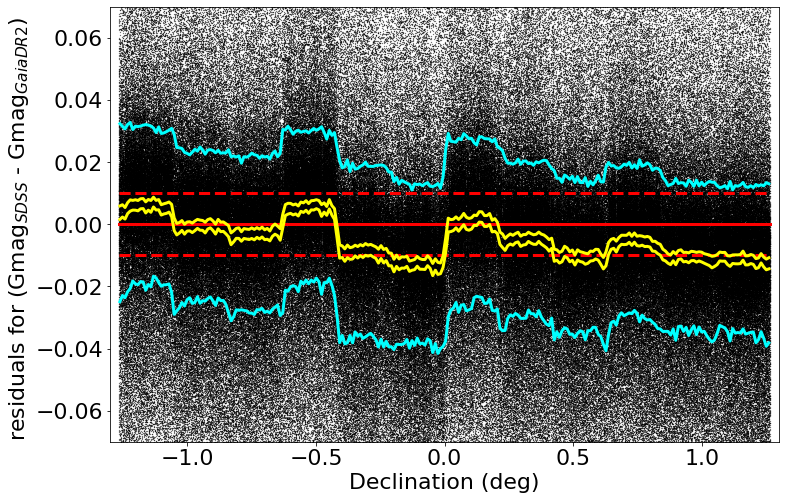

medianAll: -0.005169725051879749 std.dev.All: 0.026661151840508168
N= 823148 min= -0.09999994224548309 max= 0.09396131709289651
median: -0.005286103000640623 std.dev: 0.006149772971195267
saved plot as: GmagCorrection_Dec_Hess.png


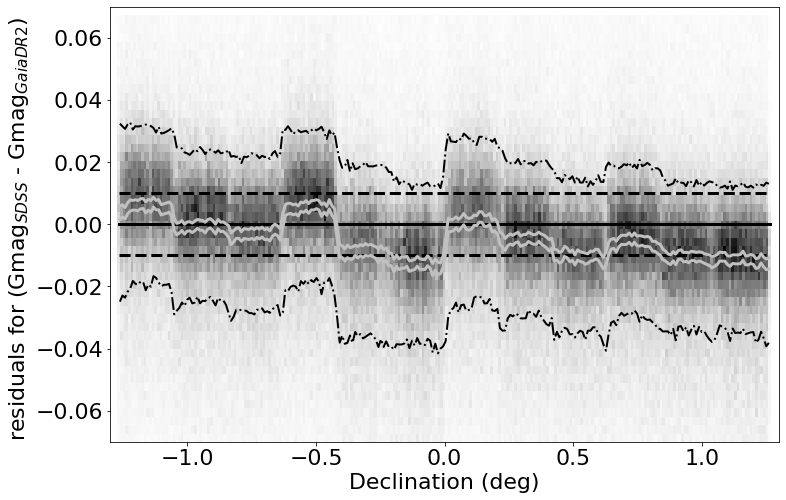

made plot GmagCorrection_Dec_Hess.png
-----------
 stats for SDSS r binning medians:
medianAll: -0.005169725051879749 std.dev.All: 0.026661151840508168
N= 823148 min= -0.09999994224548309 max= 0.09396131709289651
median: 0.00030725098037703673 std.dev: 0.009578441734778143
saved plot as: GmagCorrection_Gmag.png


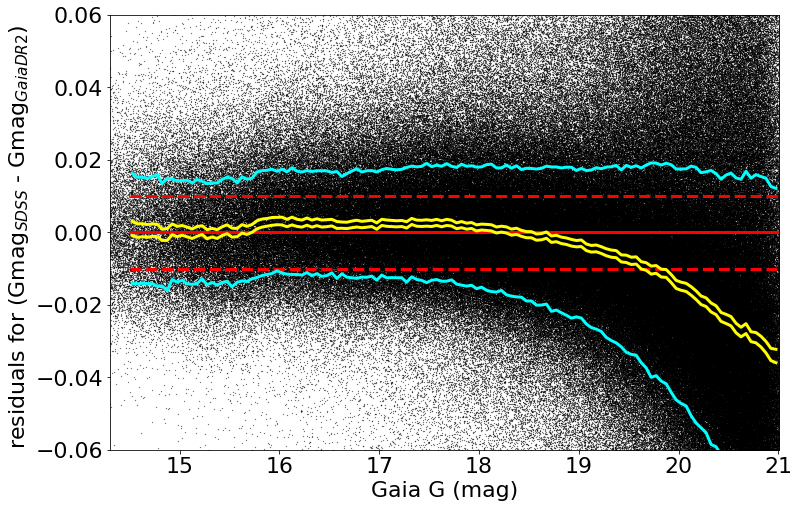

medianAll: -0.005169725051879749 std.dev.All: 0.026661151840508168
N= 823148 min= -0.09999994224548309 max= 0.09396131709289651
median: 0.00030725098037703673 std.dev: 0.009578441734778143
saved plot as: GmagCorrection_Gmag_Hess.png


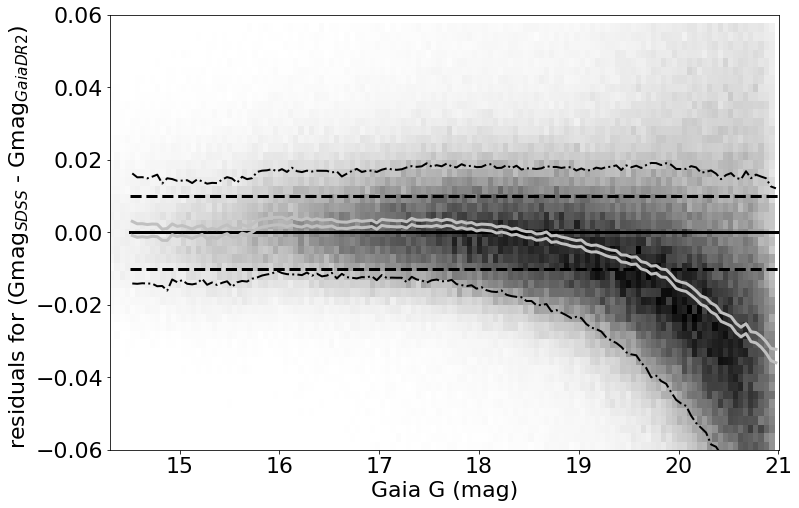

made plot GmagCorrection_Gmag_Hess.png
------------------------------------------------------------------


In [49]:
keywords = {"Ystr":'GrResid', "plotNameRoot":'GmagCorrection', "symbSize":0.05}
plotGmagCorrections(mOKok, keywords) 

In [50]:
!cp GmagCorrection_Gmag_Hess.png GmagCorrectionTest_Gmag_Hess.png

In [51]:
mOKokX = mOKok[(mOKok['Gmag']>15)&(mOKok['Gmag']<15.5)]
print(np.median(mOKokX['GrResid']))

-0.00010522235870369205


In [52]:
mOKokX = mOKok[(mOKok['Gmag']>16)&(mOKok['Gmag']<16.2)]
print(np.median(mOKokX['GrResid']))

-0.0028501700439443386


 stats for RA binning medians:
medianAll: 3.082483672824446e-05 std.dev.All: 0.017618962831136047
N= 371924 min= -0.09999827845764403 max= 0.09419973519897318
median: 0.0008602470474221302 std.dev: 0.0035382567520963527
saved plot as: GmagCorrection_RA.png


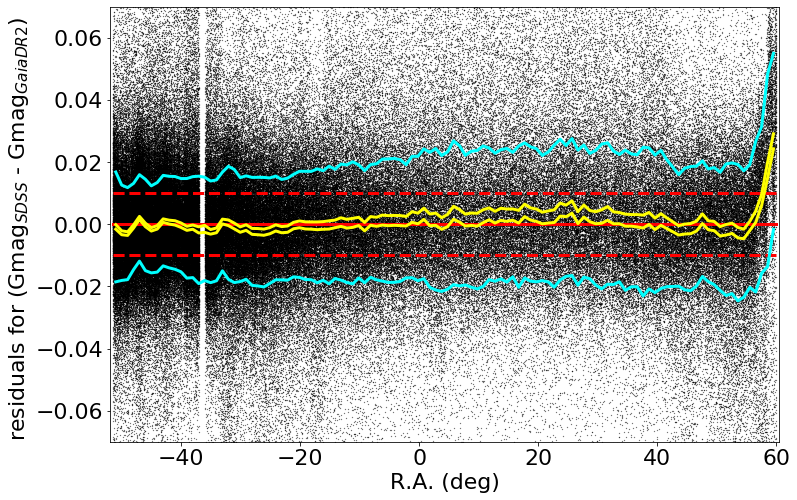

medianAll: 3.082483672824446e-05 std.dev.All: 0.017618962831136047
N= 371924 min= -0.09999827845764403 max= 0.09419973519897318
median: 0.0008602470474221302 std.dev: 0.0035382567520963527
saved plot as: GmagCorrection_RA_Hess.png


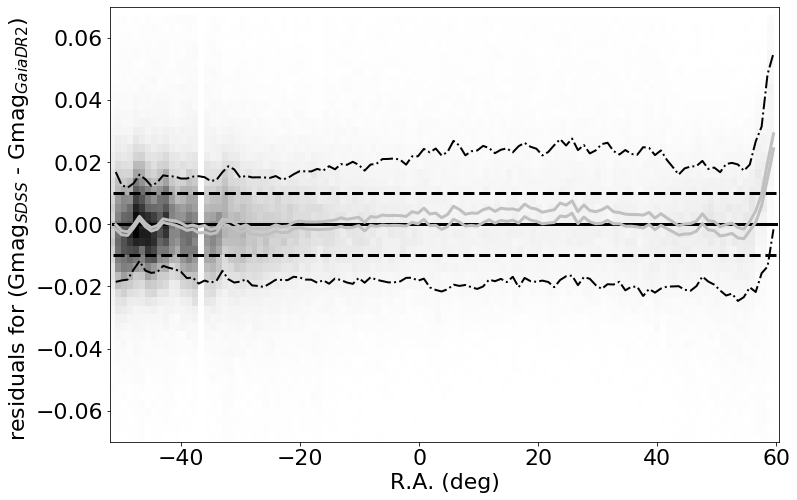

made plot GmagCorrection_RA_Hess.png
-----------
 stats for Dec binning medians:
medianAll: 3.082483672824446e-05 std.dev.All: 0.017618962831136047
N= 371924 min= -0.09999827845764403 max= 0.09419973519897318
median: -0.0006003206253064643 std.dev: 0.006226911132576704
saved plot as: GmagCorrection_Dec.png


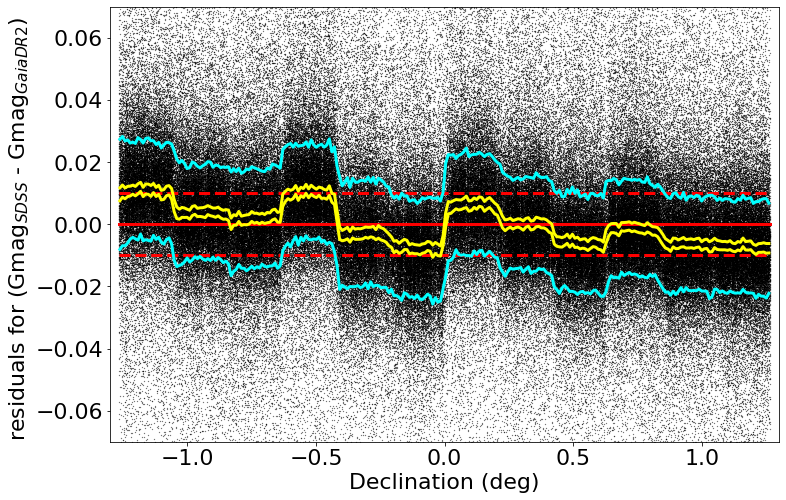

medianAll: 3.082483672824446e-05 std.dev.All: 0.017618962831136047
N= 371924 min= -0.09999827845764403 max= 0.09419973519897318
median: -0.0006003206253064643 std.dev: 0.006226911132576704
saved plot as: GmagCorrection_Dec_Hess.png


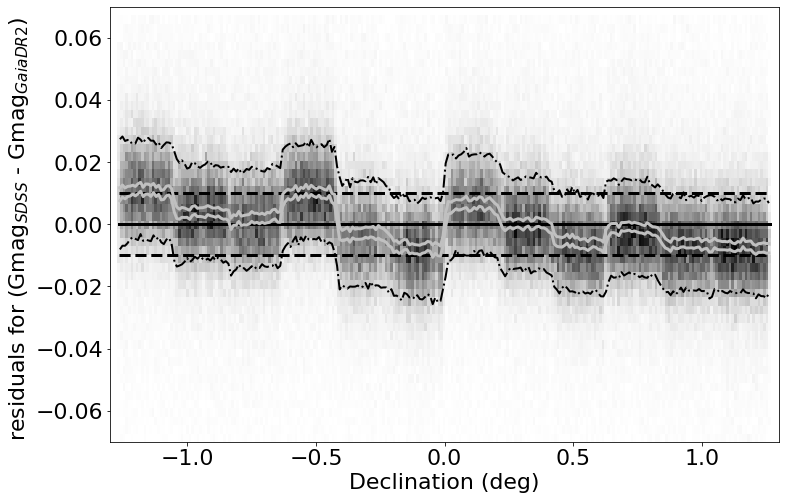

made plot GmagCorrection_Dec_Hess.png
-----------
 stats for SDSS r binning medians:
medianAll: 3.082483672824446e-05 std.dev.All: 0.017618962831136047
N= 371924 min= -0.09999827845764403 max= 0.09419973519897318
median: 0.0018725657653776168 std.dev: 0.0029630411504777123
saved plot as: GmagCorrection_Gmag.png


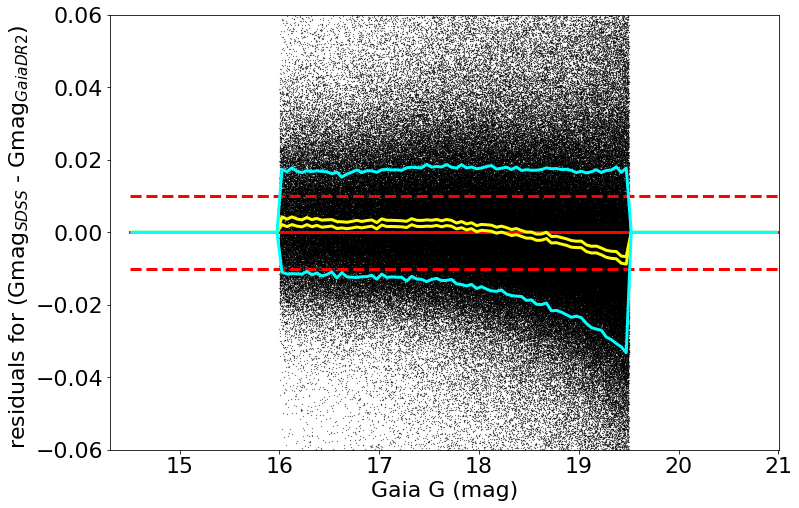

medianAll: 3.082483672824446e-05 std.dev.All: 0.017618962831136047
N= 371924 min= -0.09999827845764403 max= 0.09419973519897318
median: 0.0018725657653776168 std.dev: 0.0029630411504777123
saved plot as: GmagCorrection_Gmag_Hess.png


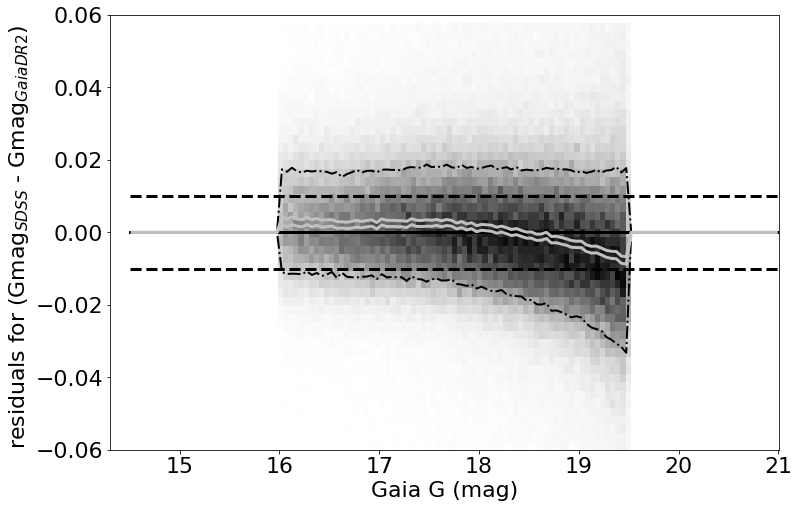

made plot GmagCorrection_Gmag_Hess.png
------------------------------------------------------------------


In [45]:
keywords = {"Ystr":'GrResid', "plotNameRoot":'GmagCorrection', "symbSize":0.05}
plotGmagCorrections(mOKcBok, keywords) 

medianAll: 0.029251443481445705 std.dev.All: 0.080934272080994
N= 393107 min= -5.769618420410158 max= 10018.48341618042
median: -0.0563277442932133 std.dev: 0.47825207054327984
saved plot as: GrVSgi.png


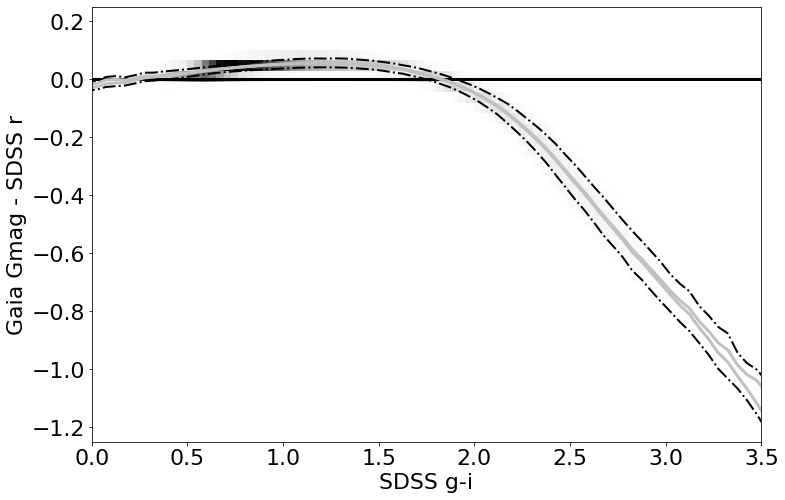

made plot GrVSgi.png


In [30]:
# for calibration: giMin = 0.4 & giMax = 3.0 
mOKB = mOK[(mOK['Gmag']>16)&(mOK['Gmag']<19.5)]
plotGmag2Ddiagrams(mOKB)

In [31]:
mOKB

<Table length=393107>
     ra        dec       nObs  ...        gGrFit                 dgGr         
  float64    float64   float64 ...       float64               float64        
----------- ---------- ------- ... -------------------- ----------------------
 25.5496845  -0.702082   105.0 ... 0.058009691589354984  0.0003208259887691467
 38.3808365  -0.805084   120.0 ...  0.03288945141601474  -0.015049397094726302
 45.6918259   1.017372    98.0 ... 0.033211333801270254  -0.006226320983887729
 12.0231018    0.60729   361.0 ...  0.03387636450195328  -0.025466556152343472
 59.7480316  -0.971882   284.0 ... 0.060653978469849296  -0.045234633377075756
 51.0403976   1.123121   131.0 ... 0.056710810470581956   -0.01488383598327652
 29.2501392   0.646297   129.0 ...  0.03605222549438473   0.005774748992920707
 41.3997459   0.645736   121.0 ...  0.03433060861206117   -0.02084259896850705
  5.4288092 -1.0197898   328.0 ...  0.03361421571350088  -0.024512854629515697
  4.3845582  -0.679951   223.0 ...  0.04286650491333064  -0.004153428131104288
        ...        ...     ... ...                  ...                    ...
351.5320129  -0.621069   210.0 ...   0.0570046079559337   0.006813376052855653
315.4645691  -0.669377   154.0 ... -0.49837468568420296    -0.1015054229583735
312.0646057   1.181761   310.0 ... -0.38382665454101605    0.07497706347656141
333.0623169 -1.0591829   114.0 ...  0.03469368972778257  -0.024439466094969206
310.5834351  1.2283032   328.0 ...  -0.5122313351287835   0.050685558761595084
334.9614868 -1.1496898   138.0 ...  -0.6291441310424801    0.11570407672119032
331.2413635  -1.073441   134.0 ...  0.03483924713134707   0.005724513244630795
320.3902893   1.189172   128.0 ... -0.20745666265869145   0.011928052429200142
325.6092529   -0.53196   137.0 ...   0.0510469183502184 -7.552857971220711e-05
329.9086914  -0.913173   134.0 ... -0.42066884887695266   -0.05233496582031194

### Final Gmag-based recalibration
#### Recalibrate R.A. residuals


In [32]:
RAbin, RAnPts, RAmedianBin, RAsigGbin = zit.fitMedians(mOKcBok['raW'], mOKcBok['GrResid'], -51.5, 60.0, 112, 1)

median: -0.0008380263824436969 std.dev: 0.0034943776777776048


#### Recalibrate Dec residuals

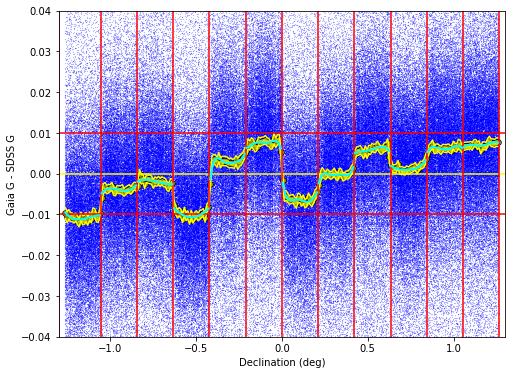

In [33]:
decOK = mOKcBok['dec_new']
GrResid =  mOKcBok['GrResid']
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(decOK, GrResid, s=0.01, c='blue')
ax.set_xlim(-1.3,1.3)
ax.set_ylim(-0.06,0.06)
ax.set_ylim(-0.04,0.04)

ax.set_xlabel('Declination (deg)')
ax.set_ylabel('Gaia G - SDSS G')
xBin, nPts, medianBin, sigGbin = zit.fitMedians(decOK, GrResid, -1.266, 1.264, 252, 0)
ax.scatter(xBin, medianBin, s=30.0, c='black', alpha=0.9)
ax.scatter(xBin, medianBin, s=15.0, c='yellow', alpha=0.5)
TwoSigP = medianBin + 2*sigGbin
TwoSigM = medianBin - 2*sigGbin 
ax.plot(xBin, TwoSigP, c='yellow')
ax.plot(xBin, TwoSigM, c='yellow')
xL = np.linspace(-100,100)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')
dCleft = -1.3
ax.plot(0*xL+dCleft, xL, c='red')
alltheta = []
for i in range(0,12):
    decCol = -1.2655 + (i+1)*0.2109
    ax.plot(0*xL+decCol, xL, c='red')
    xR = xBin[(xBin>dCleft)&(xBin<decCol)]
    yR = medianBin[(xBin>dCleft)&(xBin<decCol)]
    dyR = sigGbin[(xBin>dCleft)&(xBin<decCol)]
    data = np.array([xR, yR, dyR])
    theta2 = zit.best_theta(data,5)
    alltheta.append(theta2)
    yfit = zit.polynomial_fit(theta2, xR)
    ax.plot(xR, yfit, c='cyan', lw=2)
    dCleft = decCol
    rrr = yR - yfit
    # print(i, np.median(rrr), np.std(rrr))  # 2 milimag scatter 
    # print(i, theta2)
plt.savefig('GmagDecCorrections.png')

In [34]:
# let's now correct all mags with this correction
thetaRecalib = alltheta

In [35]:
decLeft = -1.3
for i in range(0,12):
    decRight = -1.2655 + (i+1)*0.2109
    decArr = np.linspace(decLeft, decRight, 100)
    thetaBin = thetaRecalib[i] 
    ZPfit = zit.polynomial_fit(thetaBin, decArr)
    if (i==0):
        decCorrGrid = decArr
        ZPcorr = ZPfit
    else: 
        decCorrGrid = np.concatenate([decCorrGrid, decArr]) 
        ZPcorr = np.concatenate([ZPcorr, ZPfit])
    decLeft = decRight

In [36]:
mOKtest = mOK[mOK['r_Nobs_new']>3]

In [37]:
# Dec correction
decGrid2correct = mOKtest['dec_new']
ZPcorrectionsDec = np.interp(decGrid2correct, decCorrGrid, ZPcorr)
# RA correction 
raWGrid2correct = mOKtest['raW'] 
ZPcorrectionsRA = np.interp(raWGrid2correct, RAbin, RAmedianBin)
print(np.std(ZPcorrectionsDec), np.std(ZPcorrectionsRA))

0.006223912364413222 0.0030664133283263236


Text(0, 0.5, 'Correction')

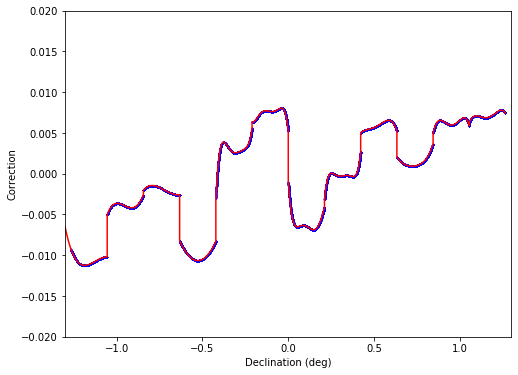

In [38]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(decGrid2correct, ZPcorrectionsDec, s=0.01, c='blue')
ax.plot(decCorrGrid, ZPcorr, c='red')
ax.set_xlim(-1.3,1.3)
ax.set_ylim(-0.02,0.02)
ax.set_xlabel('Declination (deg)')
ax.set_ylabel('Correction')

-0.02625972416686581

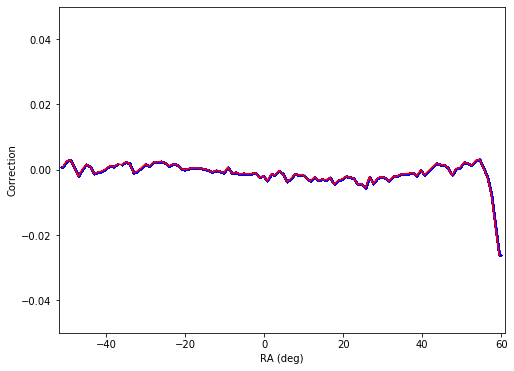

In [39]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(raWGrid2correct, ZPcorrectionsRA, s=0.01, c='blue')
ax.plot(RAbin, RAmedianBin, c='red')
ax.set_xlim(-52,61)
ax.set_ylim(-0.05,0.05)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Correction') 
np.min(ZPcorrectionsRA)

In [40]:
mOKtest['ZPcorrectionsRA'] = ZPcorrectionsRA
mOKtest['ZPcorrectionsDec'] = ZPcorrectionsDec
mOKtest['r_mMed_new'] = mOKtest['r_mMed_new'] + mOKtest['ZPcorrectionsRA'] + mOKtest['ZPcorrectionsDec']
mOKtest['gGr_new'] = mOKtest['Gmag'] - mOKtest['r_mMed_new']
mOKtest['gGrFit'] = zit.polynomial_fit(thetaCloc, mOKtest['gi'])
mOKtest['dgGr'] = mOKtest['gGr_new'] - mOKtest['gGrFit']

ERROR: NameError: name 'thetaCloc' is not defined [IPython.core.interactiveshell]


NameError: name 'thetaCloc' is not defined

In [ ]:
d = mOKtest
gi = d['gi']
Gr = d['gGr_new']
Gmag = d['Gmag']
zit.qpBM(d, 'gi', -1, 4.5, 'gGr_new', -2, 1.0, 56) 

In [ ]:
thetaCtest, DcBokTest_new = doGaiaGmagCorrection(mOKtest, 'gGr_new')

In [ ]:
keywords = {"Ystr":'gGr_new', "plotNameRoot":'GmagCorrectionTest', "symbSize":0.05}
mOKtest2 = mOKtest[(mOKtest['gi']>0.4)&(mOKtest['gi']<3.0)]
x = mOKtest2[(mOKtest2['Gmag']>14.5)&(mOKtest2['Gmag']<15.5)]
mOKtest2['gGr_new'] = mOKtest2['gGr_new'] - np.median(x['gGr_new'])  
plotGmagCorrections(mOKtest2, keywords) 

## Now save correction arrays, then apply to original file, and then test

In [ ]:
# final refers to the July 2020 analysis, before the paper submission
#np.savetxt('ZPcorrectionsRA_v3.1_final.dat', (RAbin, RAmedianBin)) 
#np.savetxt('ZPcorrectionsDec_v3.1_final.dat', (decCorrGrid, ZPcorr))

In [ ]:
sdssOut = sdss[sdss['ra_new']<1]
sdssOut = zit.selectCatalog(sdss, sdssOut)

In [ ]:
sdssOut.sort('calib_fla_new') 

In [ ]:
# read back gray zero point recalibration files 
zpRAgrid, zpRA = np.loadtxt('ZPcorrectionsRA_v3.1_final.dat')  
zpDecgrid, zpDec = np.loadtxt('ZPcorrectionsDec_v3.1_final.dat')  

In [ ]:
sdssOut

In [ ]:
# Dec correction
decGrid2correct = sdssOut['dec_new']
ZPcorrectionsDec = np.interp(decGrid2correct, zpDecgrid, zpDec)

# RA correction 
ra = sdssOut['ra_new'] 
raWGrid2correct = np.where(ra > 180, ra-360, ra) 
ZPcorrectionsRA = np.interp(raWGrid2correct, zpRAgrid, zpRA)
print('gray std RA/Dec:', np.std(ZPcorrectionsRA), np.std(ZPcorrectionsDec)) 

for b in ('u', 'g', 'r', 'i', 'z'):
    for mtype in ('_mMed_new', '_mMean_new'):
        mstr = b + mtype
        # applying here gray corrections  
        sdssOut[mstr] = sdssOut[mstr] + ZPcorrectionsRA + ZPcorrectionsDec 

In [ ]:
SSCindexRoot = 'CALIBSTARS_'
outFile = ZIdataDir + "/" + "stripe82calibStars_v3.1_noheader_final.dat"
newSSC = open(outFile,'w')
df = sdssOut
Ngood = 0
for i in range(0, np.size(df)):
    Ngood += 1
    NoldCat = df['calib_fla_new'][i]
    strNo = f'{Ngood:07}'
    SSCindex = SSCindexRoot + strNo 
    SSCrow = zit.getSSCentry(df, i)
    zit.SSCentryToOutFileRow(SSCrow, SSCindex, newSSC) 
newSSC.close()
print(Ngood, 'rows in file', outFile)

## paper plot showing the jump in Gaia Gmag

In [ ]:
np.size(zpDec)

## TEMP code for color corrections to go from 3.1 to 3.2 and 3.3 

In [ ]:
### need to figure out where were ZPcorrections2_rz_Dec.dat etc produced ... 
## color corrections 
for mtype in ('_mMed', '_mMean'):
    ## u band from u-r color
    color = 'ur'
    zpcFilename = 'ZPcorrections_' + color + '_RA.dat'
    zpcRAgrid, zpcRA = np.loadtxt(zpcFilename)   
    zpcFilename = 'ZPcorrections_' + color + '_Dec.dat'
    zpcDecgrid, zpcDec = np.loadtxt(zpcFilename)   
    ZPcorrectionsRA = np.interp(raWGrid2correct, zpcRAgrid, zpcRA) 
    ZPcorrectionsDec = np.interp(decGrid2correct, zpcDecgrid, zpcDec) 
    print('u-r std RA/Dec:', np.std(ZPcorrectionsRA), np.std(ZPcorrectionsDec)) 
    mstr = 'u' + mtype
    sdssOut[mstr] = sdssOut[mstr] - ZPcorrectionsRA - ZPcorrectionsDec 
    ## g band from g-r color
    color = 'gr'
    zpcFilename = 'ZPcorrections_' + color + '_RA.dat'
    zpcRAgrid, zpcRA = np.loadtxt(zpcFilename)   
    zpcFilename = 'ZPcorrections_' + color + '_Dec.dat'
    zpcDecgrid, zpcDec = np.loadtxt(zpcFilename)   
    ZPcorrectionsRA = np.interp(raWGrid2correct, zpcRAgrid, zpcRA) 
    ZPcorrectionsDec = np.interp(decGrid2correct, zpcDecgrid, zpcDec) 
    print('g-r std RA/Dec:', np.std(ZPcorrectionsRA), np.std(ZPcorrectionsDec)) 
    mstr = 'g' + mtype
    sdssOut[mstr] = sdssOut[mstr] - ZPcorrectionsRA - ZPcorrectionsDec 
    ## i band from r-i color
    color = 'ri'
    zpcFilename = 'ZPcorrections_' + color + '_RA.dat'
    zpcRAgrid, zpcRA = np.loadtxt(zpcFilename)   
    zpcFilename = 'ZPcorrections_' + color + '_Dec.dat'
    zpcDecgrid, zpcDec = np.loadtxt(zpcFilename)   
    ZPcorrectionsRA = np.interp(raWGrid2correct, zpcRAgrid, zpcRA) 
    ZPcorrectionsDec = np.interp(decGrid2correct, zpcDecgrid, zpcDec) 
    mstr = 'i' + mtype
    print('r-i std RA/Dec:', np.std(ZPcorrectionsRA), np.std(ZPcorrectionsDec)) 
    sdssOut[mstr] = sdssOut[mstr] + ZPcorrectionsRA + ZPcorrectionsDec 
    ## i band from r-z color
    color = 'rz'
    zpcFilename = 'ZPcorrections_' + color + '_RA.dat'
    zpcRAgrid, zpcRA = np.loadtxt(zpcFilename)   
    zpcFilename = 'ZPcorrections_' + color + '_Dec.dat'
    zpcDecgrid, zpcDec = np.loadtxt(zpcFilename)   
    ZPcorrectionsRA = np.interp(raWGrid2correct, zpcRAgrid, zpcRA) 
    ZPcorrectionsDec = np.interp(decGrid2correct, zpcDecgrid, zpcDec) 
    mstr = 'z' + mtype
    print('r-z std RA/Dec:', np.std(ZPcorrectionsRA), np.std(ZPcorrectionsDec)) 
    sdssOut[mstr] = sdssOut[mstr] + ZPcorrectionsRA + ZPcorrectionsDec 